In [18]:
import pickle  
import networkx as nx
import numpy as np
import random
import copy
import pandas as pd
import itertools
import math
from Motif_structures import * #轨道度结构
from scipy import integrate
import matplotlib.pyplot as plt
import os
import shap
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split #
from sklearn.preprocessing import StandardScaler

In [19]:
# 设置全局字体为新罗马字体
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'

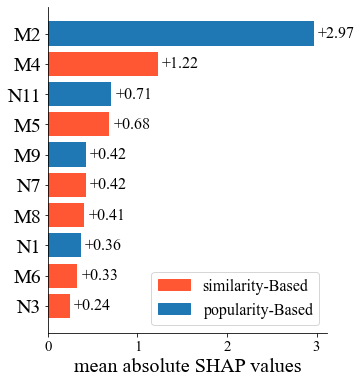

In [34]:
# Load SHAP values from CSV file
shap_values = pd.read_csv('./results/shap_values1_domain.csv', index_col=0)
network_132_social = list(shap_values['n_132'])

# Initialize lists for feature keys and SHAP values
all_keys = []
values = []
rest_values = 0

# Extract feature keys and SHAP values from the data
for i, s in enumerate(network_132_social[:-1]):
    # Clean the string and split into key-value pairs
    s = s.strip('()').replace("'", "").replace(' ', '')
    output_list = s.split(',')

    if i < 10:  # Store only the first 10 features
        all_keys.append(output_list[0])  # Feature key
        values.append(float(output_list[1]))  # Corresponding SHAP value
    else:  # Sum the remaining SHAP values
        rest_values += float(output_list[1])

# Convert values to a NumPy array for plotting
shap_values_list = np.array(values)

# Define colors for similarity-based and popularity-based features
color1 = '#FF5733'  # Color for similarity-based features
color2 = '#1F77B4'  # Color for popularity-based features

# Create a color list based on feature type
colors = [color1 if key.startswith('M') else color2 for key in all_keys]

# Create a horizontal bar plot
fig, ax = plt.subplots(figsize=(5, 6))
bars = ax.barh(all_keys[::-1], shap_values_list[::-1], color=colors)  # Use the color list

# Update plot aesthetics
plt.rcParams.update({'font.size': 16})
ax.tick_params(axis='y', labelsize=20)
ax.set_xlabel('mean absolute SHAP values', fontsize=20)

# Add value labels next to the bars
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.05, bar.get_y() + bar.get_height() / 2, f'+{width:.2f}', va='center')

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add a legend
legend_elements = [
    plt.Rectangle((0, 0), 1, 1, color=color1), 
    plt.Rectangle((0, 0), 1, 1, color=color2)
]
ax.legend(handles=legend_elements, labels=['similarity-Based', 'popularity-Based'], loc='lower right')

# Save the figure
plt.savefig('./figures/feature_analyses_net_132.pdf', dpi=700, bbox_inches='tight')
plt.show()


./features/n_132_features.csv
(169, 27)


[12:35:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


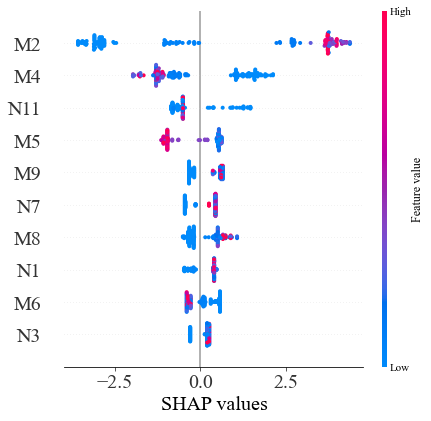

In [35]:
# Define the file path for the feature data
file_path = f'./features/n_132_features.csv'
print(file_path)

# Load the network data from the CSV file
network_data = pd.read_csv(file_path)

# Define node and edge features
node_features = ['N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7', 'N8', 'N9', 'N10', 'N11', 'N12', 'N13', 'N14', 'N15']
edge_features = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'M10', 'M11', 'M12']

# Set the best parameters for the classifier
best_params = {'eval_metric': 'auc'}

# Combine selected features
selected_features = node_features + edge_features

# Prepare the feature matrix and target vector
X = network_data[selected_features]
y = network_data['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)

# Initialize and train the XGBoost classifier
xgbc = XGBClassifier(**best_params)
xgbc.fit(X_train, y_train)

# Calculate SHAP values
explainer = shap.TreeExplainer(xgbc)
shap_values = explainer.shap_values(X_test)

# Set font size for the plot
plt.rcParams['font.size'] = 15
print(shap_values.shape)

# Create a SHAP summary plot
fig = shap.summary_plot(shap_values, X_test, feature_names=selected_features, show=False, max_display=10)

# Get the current axes and figure
ax = plt.gca()
fig = plt.gcf()

# Adjust the figure size to the desired dimensions
fig.set_size_inches(6, 6)

# Set the font size for the x-axis and y-axis tick labels
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

# Set the x-axis label
ax.set_xlabel("SHAP values", fontsize=20)

# Optionally save the plot as a PDF file
plt.savefig(f'./figures/feature_analyses_net_132_SHAP.pdf', dpi=700, bbox_inches='tight')

# Display the plot
plt.show()


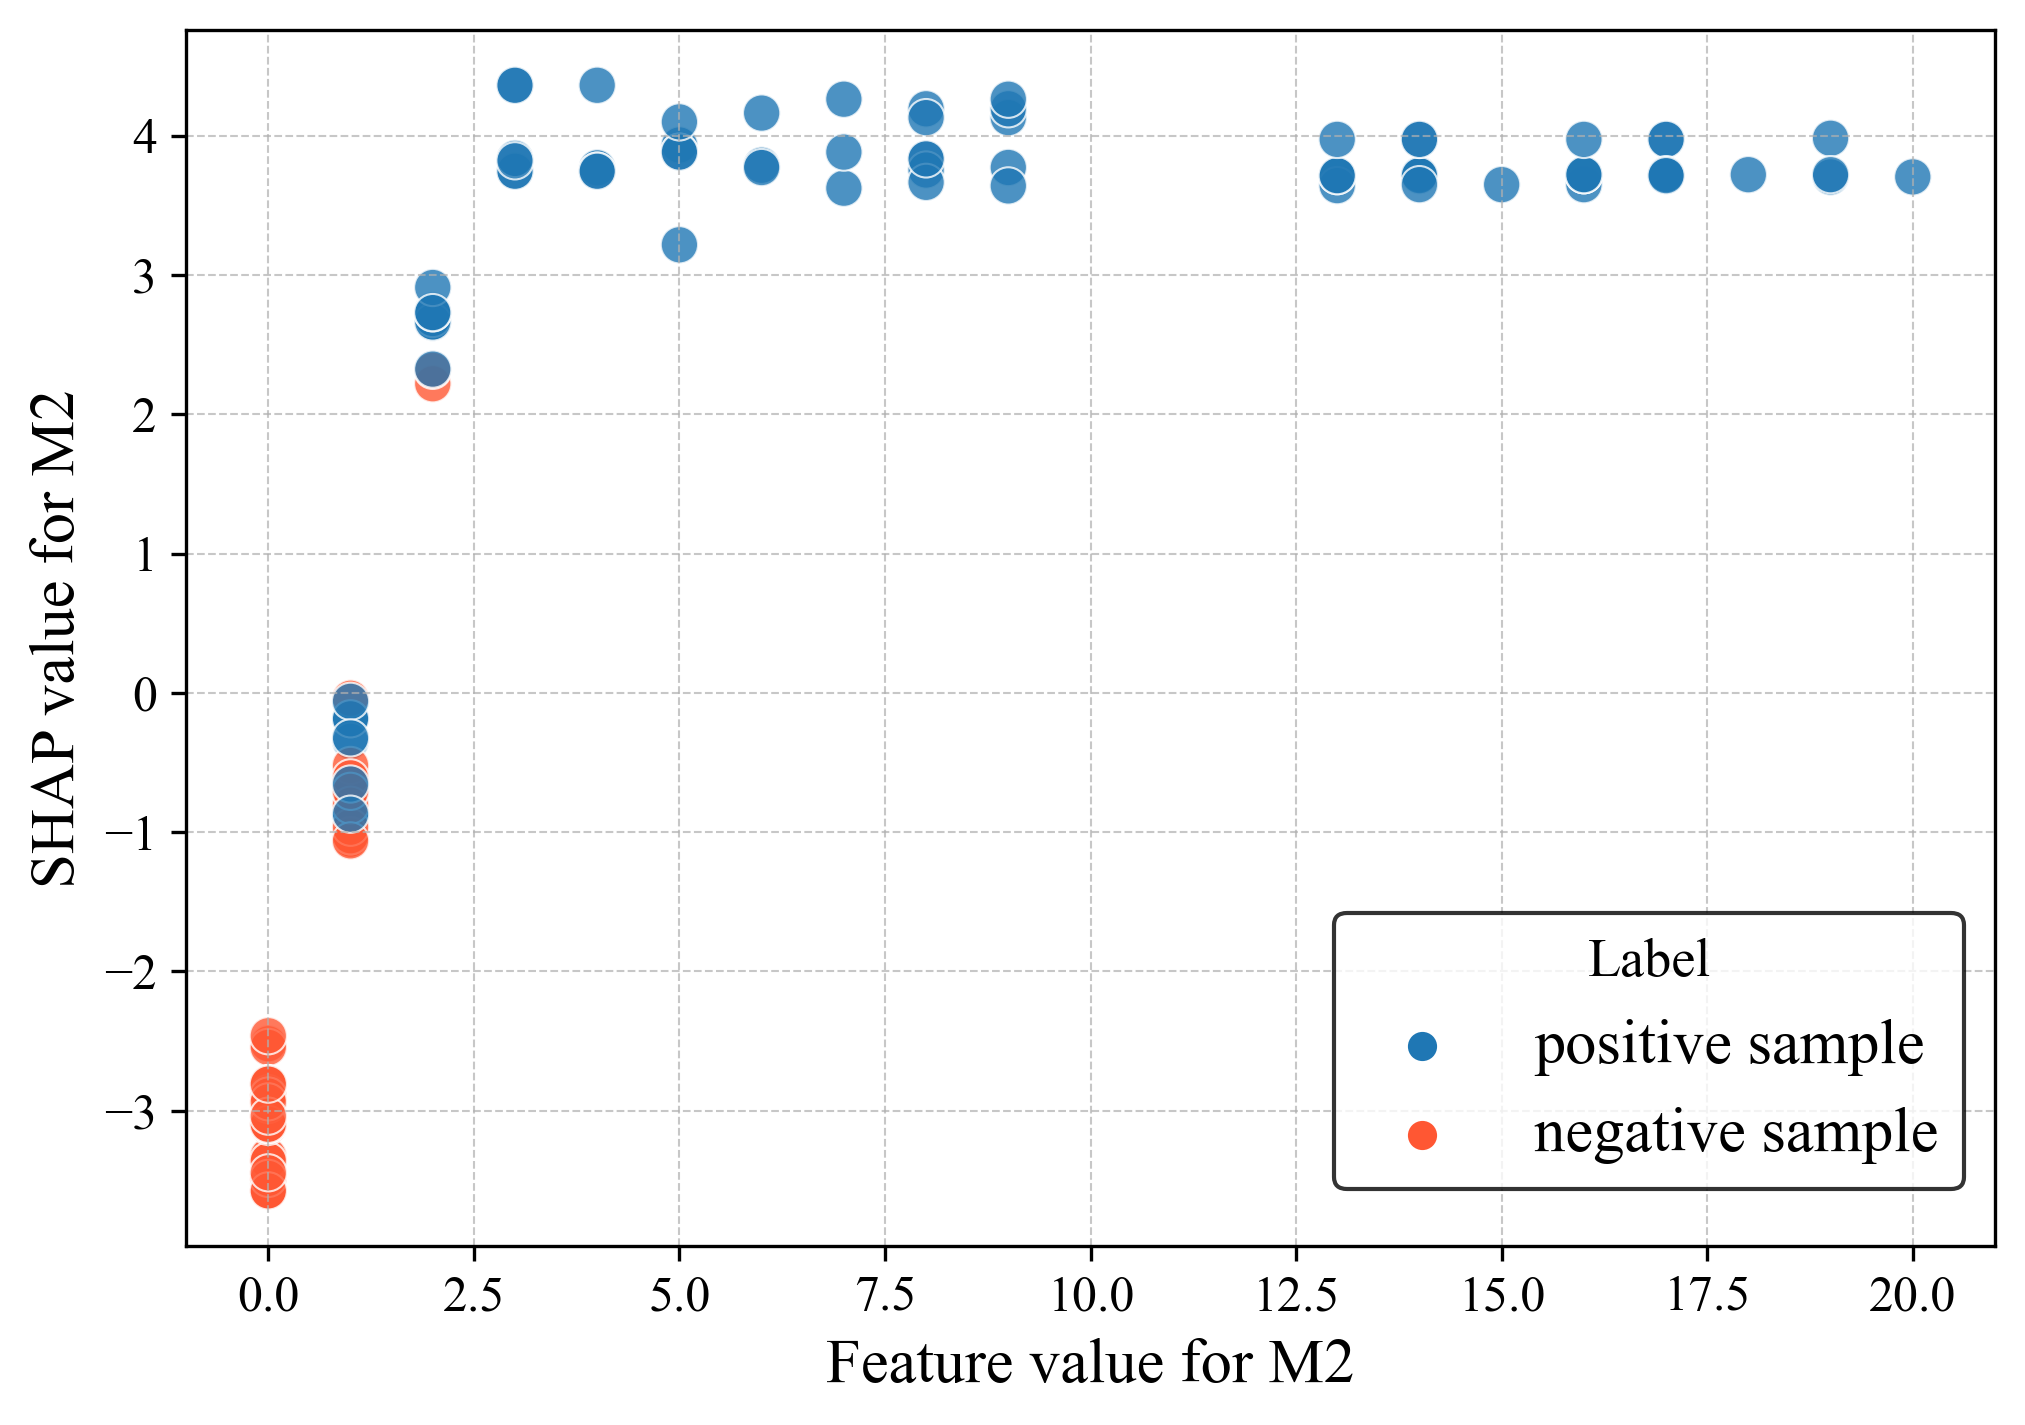

In [36]:
import seaborn as sns

# Extract the feature values and corresponding SHAP values for feature 'M2'
M2_values = X_test['M2']
shap_values_M2 = shap_values[:, X_test.columns.get_loc('M2')]

# Create a new DataFrame for plotting
plot_data = pd.DataFrame({
    'M2': M2_values,                # Feature values for M2
    'SHAP_value': shap_values_M2,   # Corresponding SHAP values
    'label': y_test                  # True labels for the samples
})

# Convert the labels to descriptive text
plot_data['label'] = plot_data['label'].map({0: 'negative sample', 1: 'positive sample'})

# Define colors for each category
palette = {'negative sample': '#FF5733', 'positive sample': '#1F77B4'}

# Create a scatter plot
plt.figure(figsize=(7, 5), dpi=300)
sns.scatterplot(data=plot_data, x='M2', y='SHAP_value', hue='label', palette=palette, alpha=0.8, s=80, edgecolor='w', linewidth=0.5)

# Set the x and y labels
plt.xlabel('Feature value for M2', fontsize=15)
plt.ylabel('SHAP value for M2', fontsize=15)

# Customize tick label sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Customize the legend
plt.legend(title='Label', title_fontsize='13', fontsize='15', loc='upper right', bbox_to_anchor=(1, 0.3), frameon=True, edgecolor='black')

# Enable grid lines for better readability
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Adjust the layout to prevent clipping of labels
plt.tight_layout()

# Optionally save the high-resolution figure
plt.savefig('./figures/feature_analyses_SHAP_M2.pdf', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()



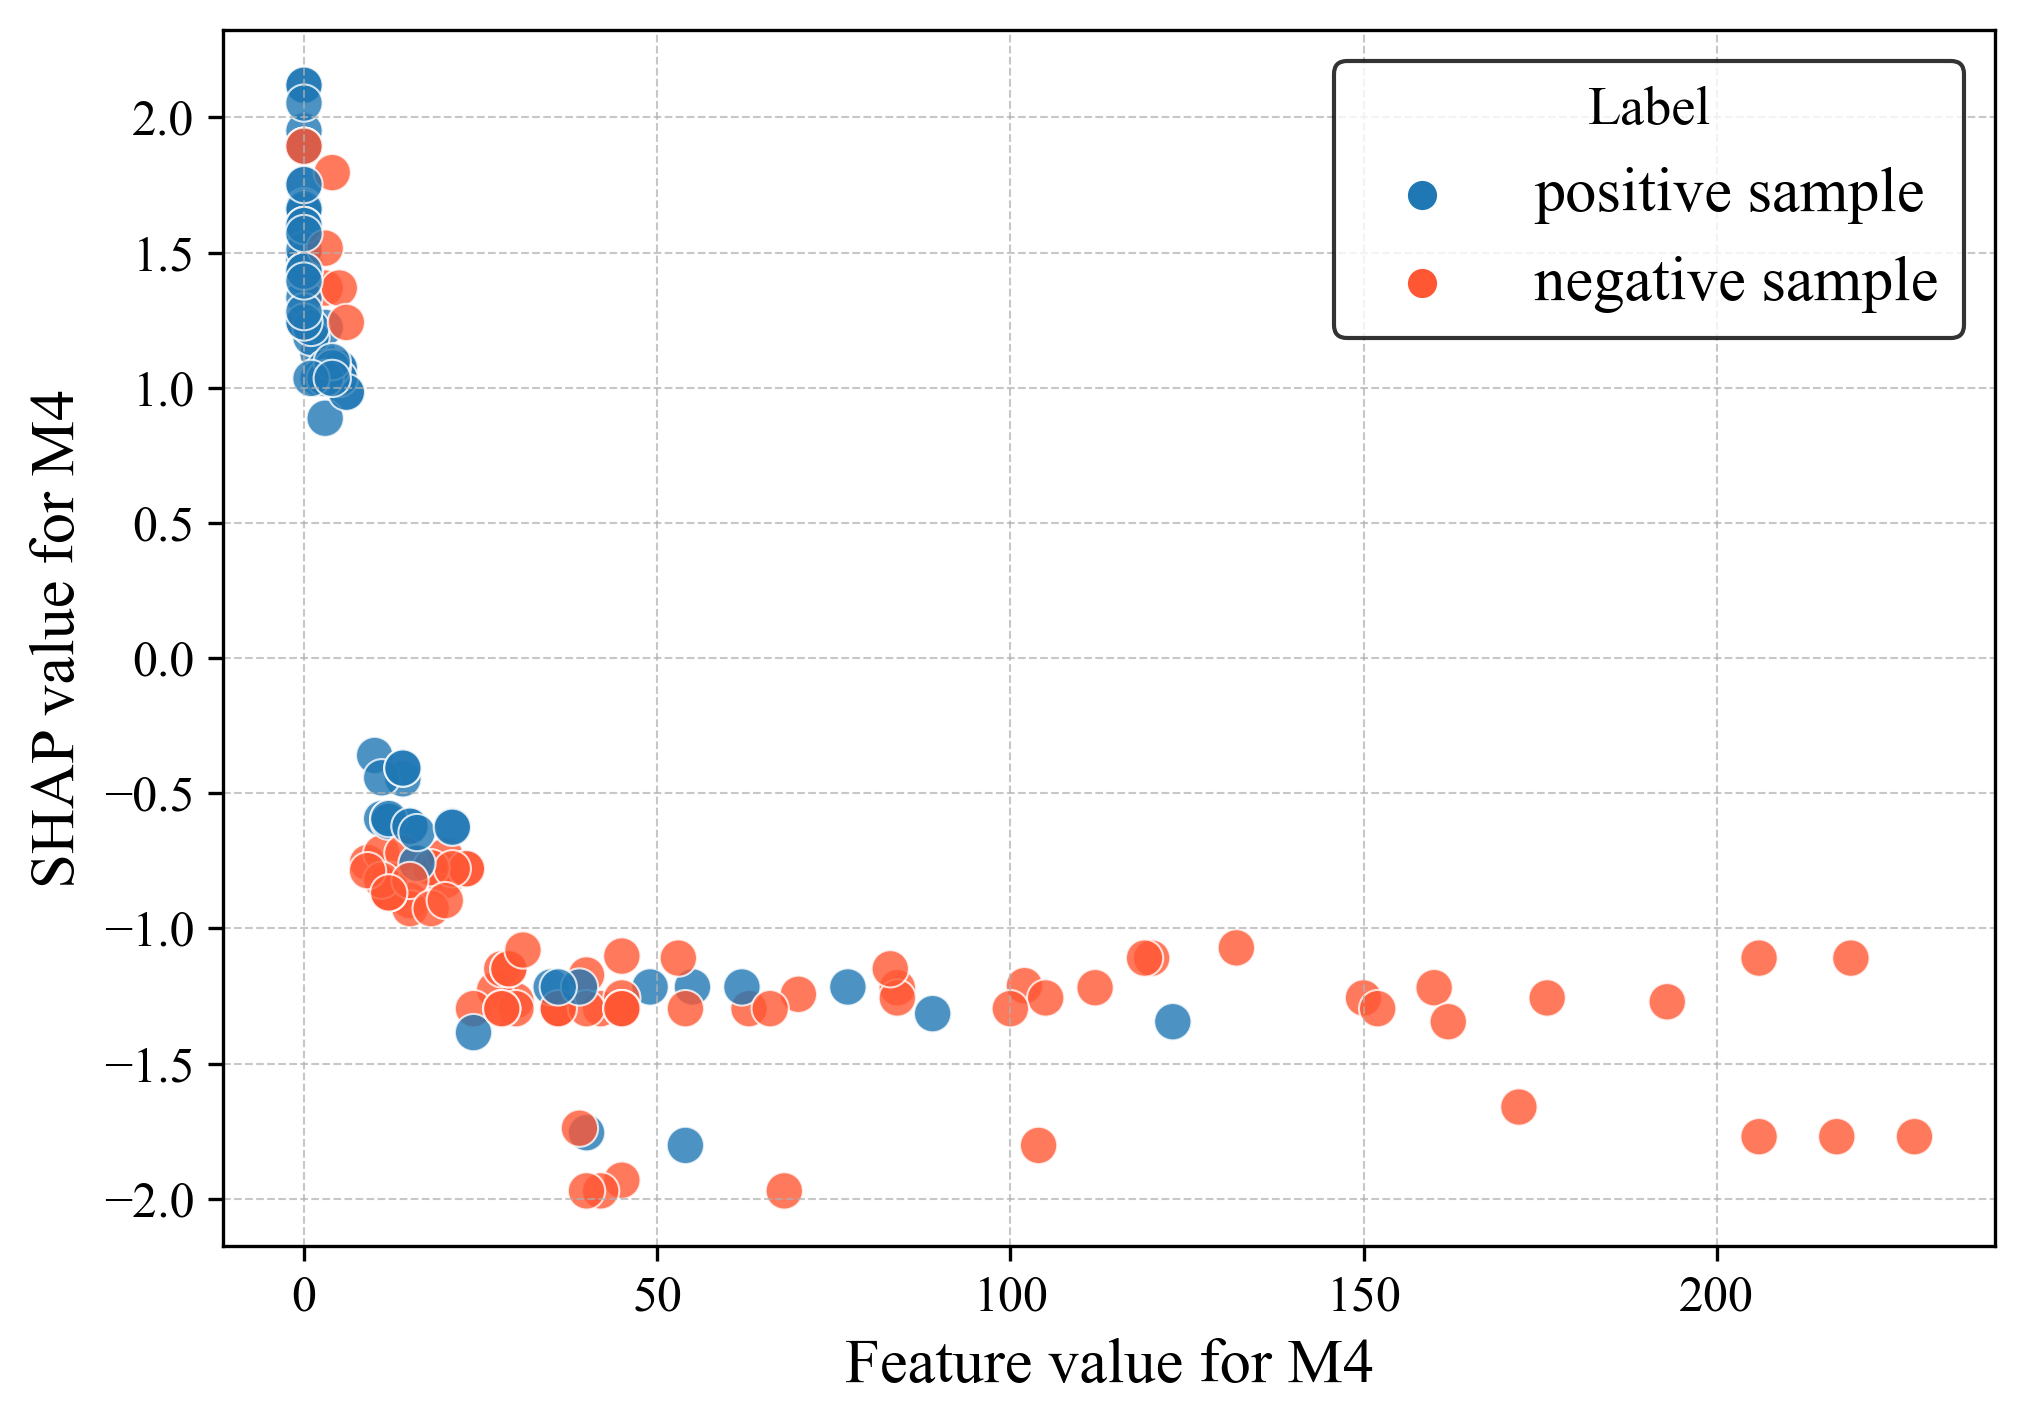

In [37]:
# Extract the feature values and corresponding SHAP values for feature 'M4'
M4_values = X_test['M4']
shap_values_M4 = shap_values[:, X_test.columns.get_loc('M4')]

# Create a new DataFrame for plotting
plot_data = pd.DataFrame({
    'M4': M4_values,                # Feature values for M4
    'SHAP_value': shap_values_M4,   # Corresponding SHAP values
    'label': y_test                  # True labels for the samples
})

# Convert the labels to descriptive text
plot_data['label'] = plot_data['label'].map({0: 'negative sample', 1: 'positive sample'})

# Define colors for each category
palette = {'negative sample': '#FF5733', 'positive sample': '#1F77B4'}

# Create a scatter plot
plt.figure(figsize=(7, 5), dpi=300)
sns.scatterplot(data=plot_data, x='M4', y='SHAP_value', hue='label', palette=palette, alpha=0.8, s=80, edgecolor='w', linewidth=0.5)

# Set the x and y labels
plt.xlabel('Feature value for M4', fontsize=15)
plt.ylabel('SHAP value for M4', fontsize=15)

# Customize tick label sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Customize the legend
plt.legend(title='Label', title_fontsize='13', fontsize='15', loc='upper right', bbox_to_anchor=(1, 1), frameon=True, edgecolor='black')

# Enable grid lines for better readability
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Adjust the layout to prevent clipping of labels
plt.tight_layout()

plt.savefig('./figures/feature_analyses_SHAP_M4.pdf', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

